<a href="https://colab.research.google.com/github/prakash-bisht/NN_architecture_from-_scratch/blob/main/yolov5_implementation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# the yolov5 architecture can be conceptually separated into three chunks:

# 1--The backbone, whose task is to extract deep-level features (feature-extractor).
# 2--The neck combines information from layers of different depths (feature aggregator).
# 3--The heads are responsible for the predictions.

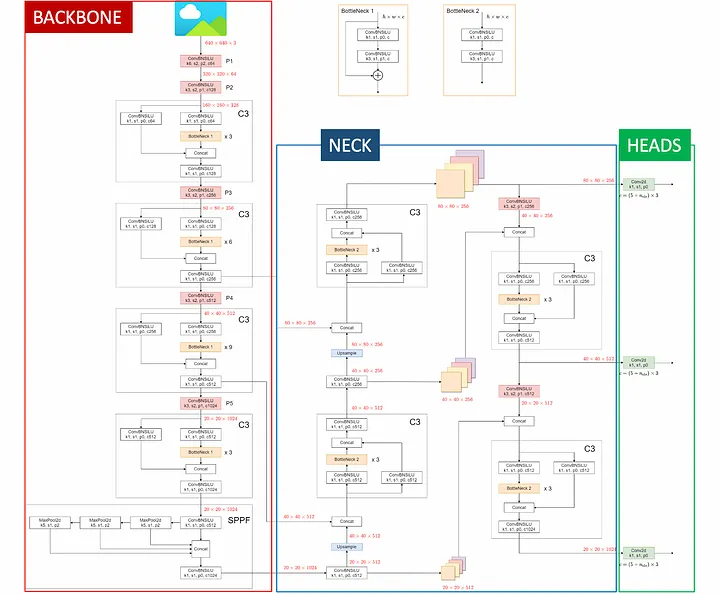

input_layer

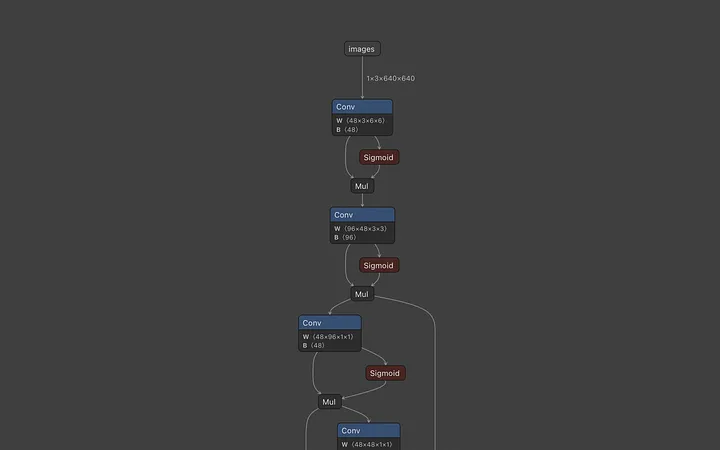

output_layer 

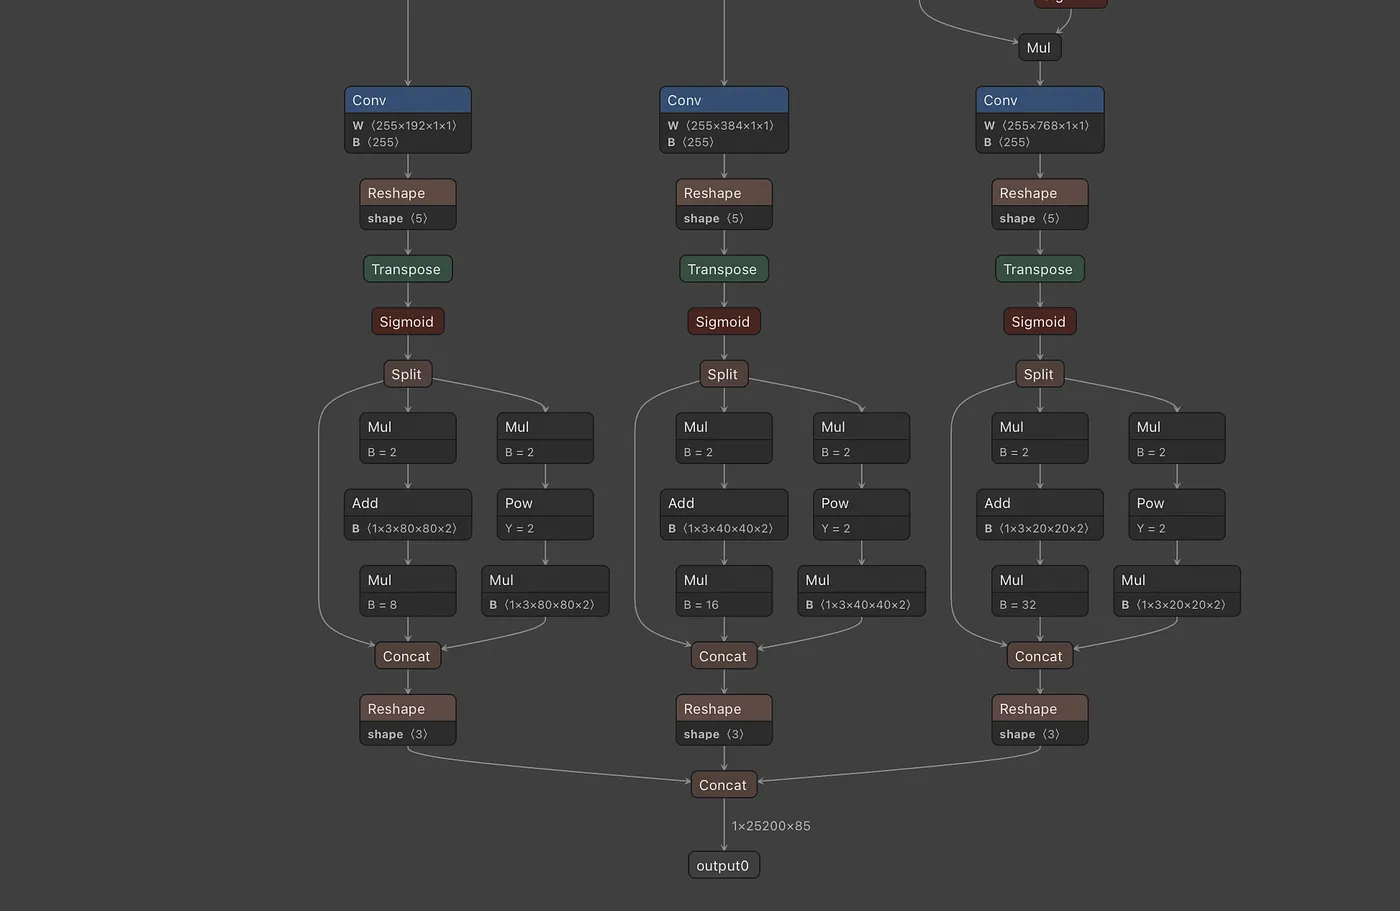

In [ ]:
# The first step was creating a CBL class that is used throughout the whole architecture:
# CBL = Convolution + Barch Norm + SiLU activation.

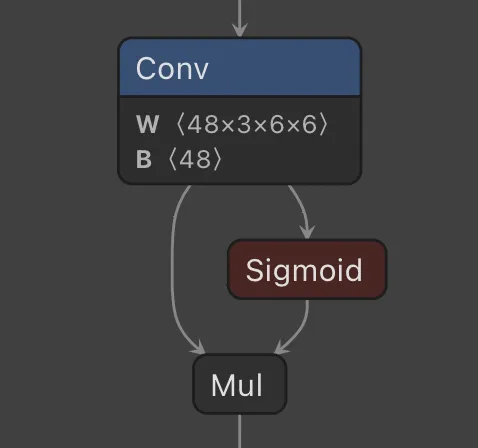

In [3]:
import torch.nn as nn 
class CBL(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size,stride,padding):
    super(CBL,self).__init__()
    conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
    batch_norm = nn.BatchNorm2d(out_channels,eps=1e-3,momentum=0.03)
    self.cbl = nn.Sequential(conv,
                             batch_norm,
                             nn.SiLU(inplace=True))
  def forward(self,x):
    return self.cbl(x)

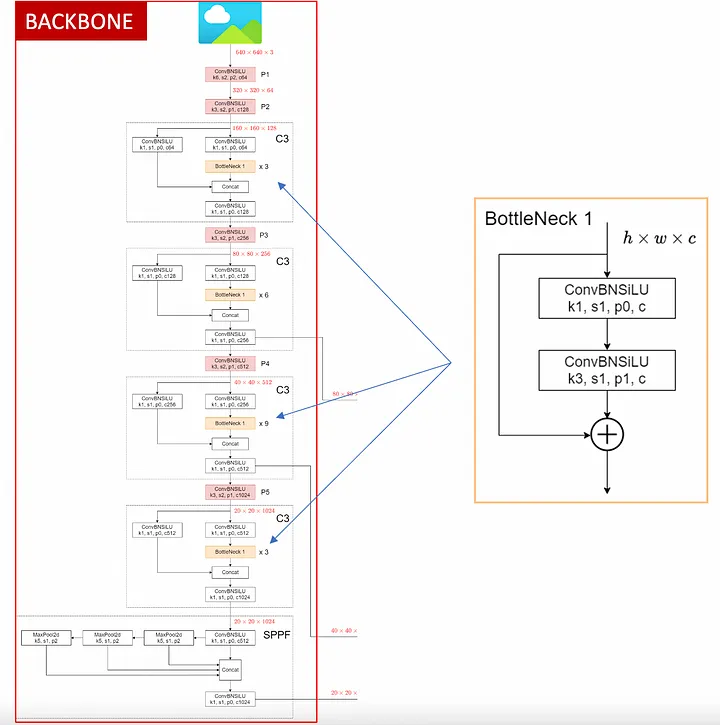

In [ ]:
# As shown in the images, the backbone is composed of the following CNN blocks:

# ConvBNSiLU (the CBL defined above)
# BottleNeck 1
# C3
# SPPF
# BottleNeck 1 is used to build the C3 block (it’s embedded),

In [ ]:
class Bottleneck(nn.Module):
    """
    Parameters:
        in_channels (int): number of channel of the input tensor
        out_channels (int): number of channel of the output tensor
        width_multiple (float): it controls the number of channels (and weights)
                                of all the convolutions beside the
                                first and last one. If closer to 0,
                                the simpler the modelIf closer to 1,
                                the model becomes more complex
    """
    def __init__(self,in_channels,out_channels,width_multiple):
      super(Bottleneck,self).__init__()
      c_ = int(width_multiple*in_channels)
      self.cbl1 = CBL(in_channels,c_,kernel_size=1,stride=1,padding=0)
      self.cbl2 = CBL(c_,out_channels,kerne_size=3,stride=1,padding=1)

    def forward(self,x):
      return self.cbl2(self.cbl1(x)) + x 

In [ ]:
"""Bottleneck 1 is a residual block with two skipped connections that, besides improving gradient back-propagation, 
comes with a width_multiple parameter. This parameter, usually referred to as the expansion factor, 
controls how much we want to squeeze and re-expand the number of channels between c1 and c2."""

C3

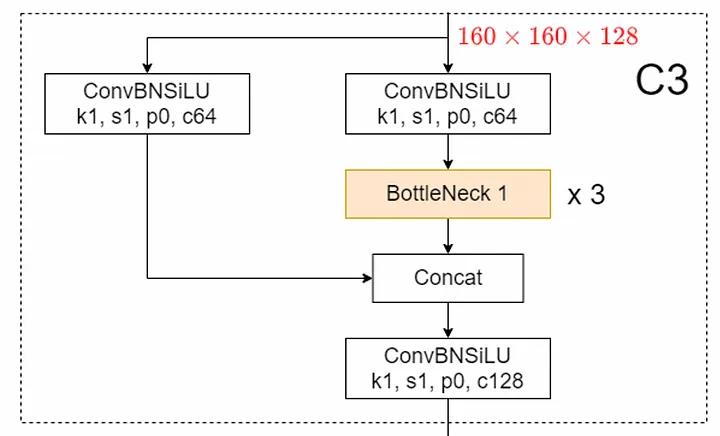

In [ ]:
import torch 
class C3(nn.Module):
    """
    Parameters:
        in_channels (int): number of channel of the input tensor
        out_channels (int): number of channel of the output tensor
        width_multiple (float): it controls the number of channels (and weights)
                                of all the convolutions beside the
                                first and last one. If closer to 0,
                                the simpler the modelIf closer to 1,
                                the model becomes more complex
        depth (int): it controls the number of times the bottleneck (residual block)
                        is repeated within the C3 block
        backbone (bool): if True, self.seq will be composed by bottlenecks 1, if False
                            it will be composed by bottlenecks 2 (check in the image linked below)
        https://user-images.githubusercontent.com/31005897/172404576-c260dcf9-76bb-4bc8-b6a9-f2d987792583.png
    """
    def __init__(self,in_channels,out_channels,width_multiple,depth,backbone=True):
      super(C3,self).__init__()
      c_ = int(width_multiple*in_channels)
      self.cbl1 = CBL(in_channels,c_,kernel_size=1,stride=1,padding=1)
      self.skipped_cbl = CBL(in_channels,c_,kernel_size=1,stride=1,padding=1)
      if backbone:
        self.seq = nn.Sequential(
            *[Bottleneck(c_,c_,width_multiple) for _ in range(depth)]
        )
      else:
        self.seq = nn.Sequential(
            *[nn.Sequential(CBL(c_,c_,1,1,0),
                            CBL(c_,c_,3,1,1)) for _ in range(depth)]
        )
      self.cbl2_out = CBL(c_ * 2,out_channels,kernel_size=1,stride=1,padding=1)

    def forward(self,x):
      x = torch.cat([self.seq(self.cbl1(x)),self.skipped_cbl],dim=1)
      return self.cbl2_out(x)


In [ ]:
# The last CNN block used to build the backbone is the SPPF (Spatial Pyramid Pooling Fast) which is a faster variant of the SPP layer

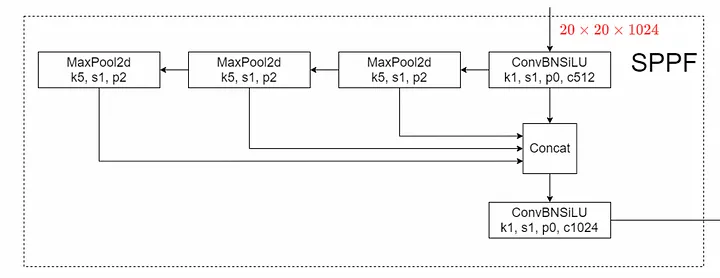

In [ ]:
class SPPF(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(SPPF,self).__init__()
    c_ = int(in_channels//2)
    self.cbl1 = CBL(in_channels,c_,1,1,0)
    self.pool = nn.MaxPool2d(kernel_size=5,stride=1,padding=2)
    self.cbl2_out = CBL(c_ * 4,out_channels,1,1,0)

  def forward(self,x):
    x = self.cbl1(x)
    pool1 = self.pool(x)
    pool2 = self.pool(pool1)
    pool3 = self.pool(pool2)
    return self.cbl2_out(torch.cat([x,pool1,pool2,pool3],dim=1))


In [ ]:
%%writefile backbone.py
self.backbone += [
    CBL(in_channels=3, out_channels=first_out, kernel_size=6, stride=2, padding=2),
    CBL(in_channels=first_out, out_channels=first_out*2, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*2, out_channels=first_out*2, width_multiple=0.5, depth=2),
    CBL(in_channels=first_out*2, out_channels=first_out*4, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*4, out_channels=first_out*4, width_multiple=0.5, depth=4),
    CBL(in_channels=first_out*4, out_channels=first_out*8, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*8, out_channels=first_out*8, width_multiple=0.5, depth=6),
    CBL(in_channels=first_out*8, out_channels=first_out*16, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*16, out_channels=first_out*16, width_multiple=0.5, depth=2),
    SPPF(in_channels=first_out*16, out_channels=first_out*16)
]

Writing backbone.py


In [ ]:
# Yolov5 neck is PANet style (Path Aggregation Network).

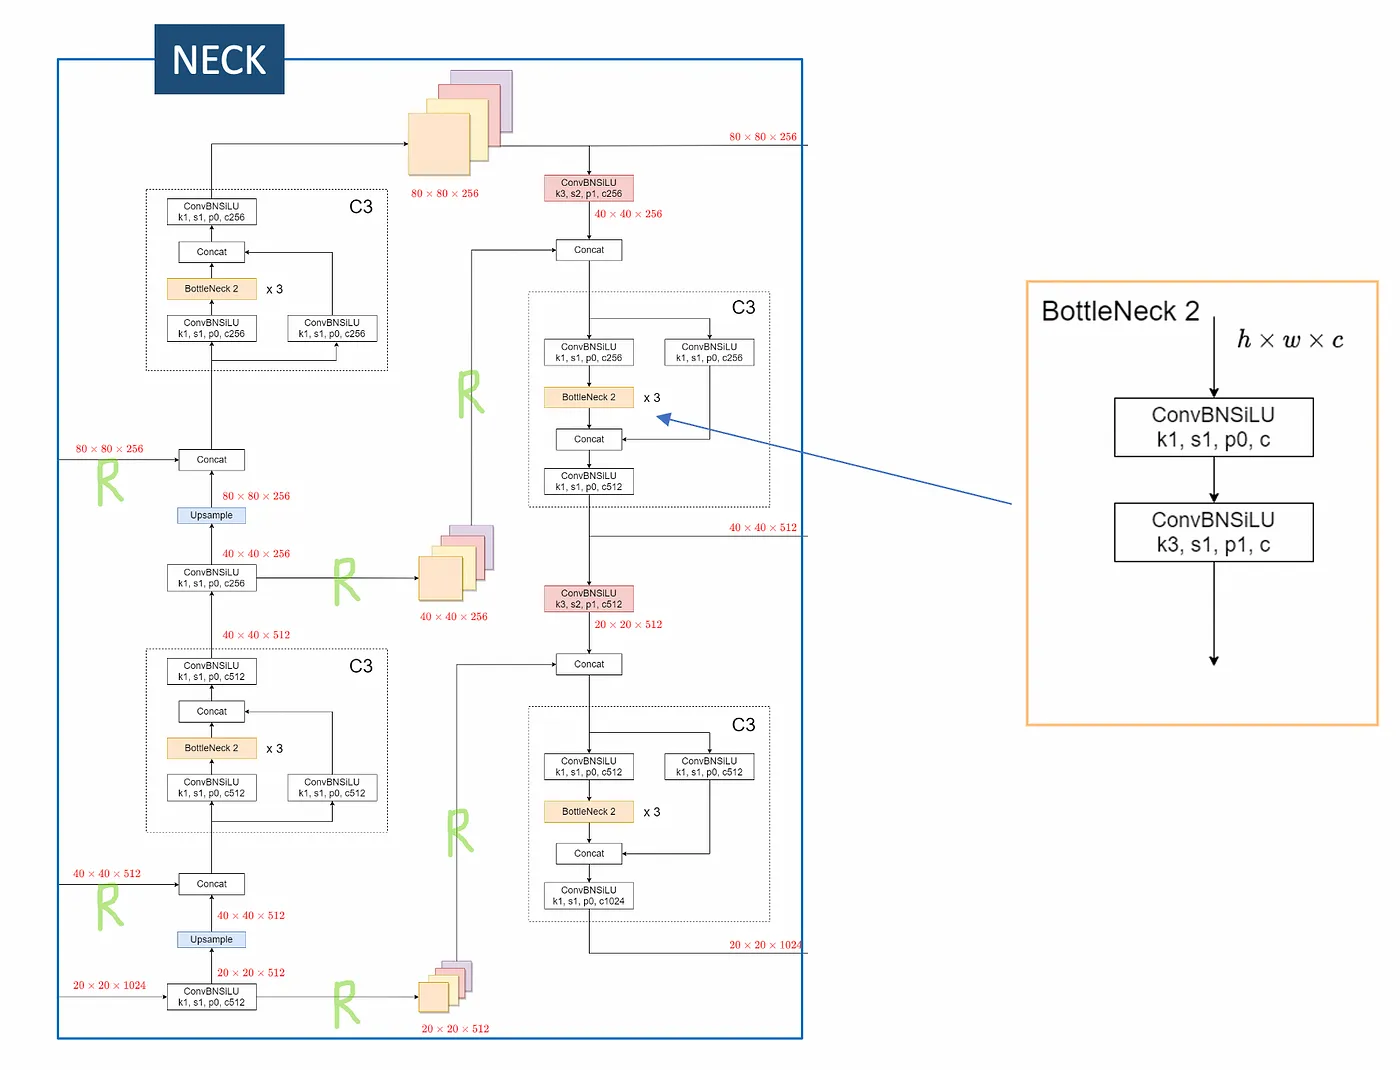

In [ ]:
# PANet stands for “Path Aggregation Network” and its core functionality is to enhance the flow of information between 
# the lower layers and topmost features via route connections, marked in the image above with “R”. 
# If you look at the image above, in fact you can notice:

# Features from different depths of the backbone that are combined (concatenated) into the neck (the two “R” in the left).
# Features from the beginning of the neck are concatenated with features in the last part of the neck 
# that precede the heads (the four “R” in the middle)

# In terms of CNN blocks, the neck is composed by these operations:

# ConvBNSiLU
# BottleNeck 2
# C3
# Upsample
# Concat

# As you remember, in the backbone, inside the C3 blocks, we were using “bottleneck 1” which is characterized by the skipped connection. 
# The “bottleneck 2”, on the other hand, it’s just a sequence of two convolutions

In [ ]:
"""The C3 class is the same used in the backbone previously, 
with the difference that here we are setting the C3's parameter backbone=False."""

In [1]:
%%writefile neck.py 
self.neck = nn.ModuleList()
self.neck += [
    CBL(in_channels=first_out*16, out_channels=first_out*8, kernel_size=1, stride=1, padding=0),
    C3(in_channels=first_out*16, out_channels=first_out*8, width_multiple=0.25, depth=2, backbone=False),
    CBL(in_channels=first_out*8, out_channels=first_out*4, kernel_size=1, stride=1, padding=0),
    C3(in_channels=first_out*8, out_channels=first_out*4, width_multiple=0.25, depth=2, backbone=False),
    CBL(in_channels=first_out*4, out_channels=first_out*4, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*8, out_channels=first_out*8, width_multiple=0.5, depth=2, backbone=False),
    CBL(in_channels=first_out*8, out_channels=first_out*8, kernel_size=3, stride=2, padding=1),
    C3(in_channels=first_out*16, out_channels=first_out*16, width_multiple=0.5, depth=2, backbone=False)
]

Writing neck.py


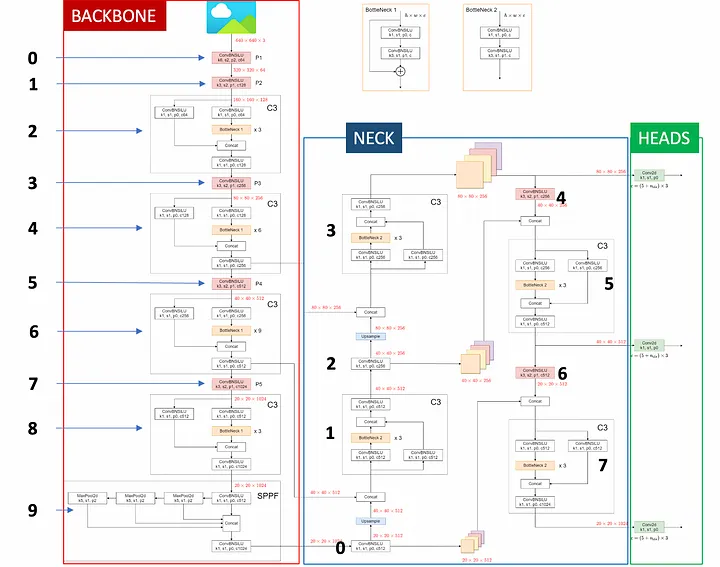

In [ ]:
# In YOLOV5 forward() shown below, you can notice that:

# If a backbone layer is a C3 and the idx is 4 or 6, we append the output to a list used to store backbone route connections.

# If a neck layer has idx 0 or 2, we store the output to a list containing neck route connections, 
# then we resize the tensor (same as Upsample), and concatenate it with the last element of the 
# backbone route connections (that is deleted with .pop() ).

# If a neck layer has idx 4 or 6, the output layer is concatenated with the last element of the 
# neck route connections (that is deleted with .pop() ).

# Lastly, If a neck layer is C3 and the idx is greater than 2, 
# we store the output tensor to a list that will be then fed to the model heads to perform a prediction.

In [2]:
def forward(self,x):
  backbone_connection = []
  neck_connection = []
  outputs = []
  for idx,layer in enumerate(self.backbone):
    x = layer(x)
    if idx in [4,6]:
      backbone_connection.append(x)

  for idx,layer in enumerate(self.neck):
    if idx in [0,2]:
      x = layer(x)
      neck_connection.append(x)
      x = Resize([x.shape[2]*2,x.shape[3]*2],interpolation=InterpolationMode.NEAREST)(x)
      x = torch.cat([x,backbone_connection.pop(-1)],dim=1)

    elif idx in [4,6]:
      x = layer(x)
      x = torch.cat([x,neck_connection.pop(-1)],dim=1)

    elif isinstance(layer,C3) and idx > 2:
      x = layer(x)
      outputs.append(x)

    else:
      x = layer(x)

  return self.head(outputs)

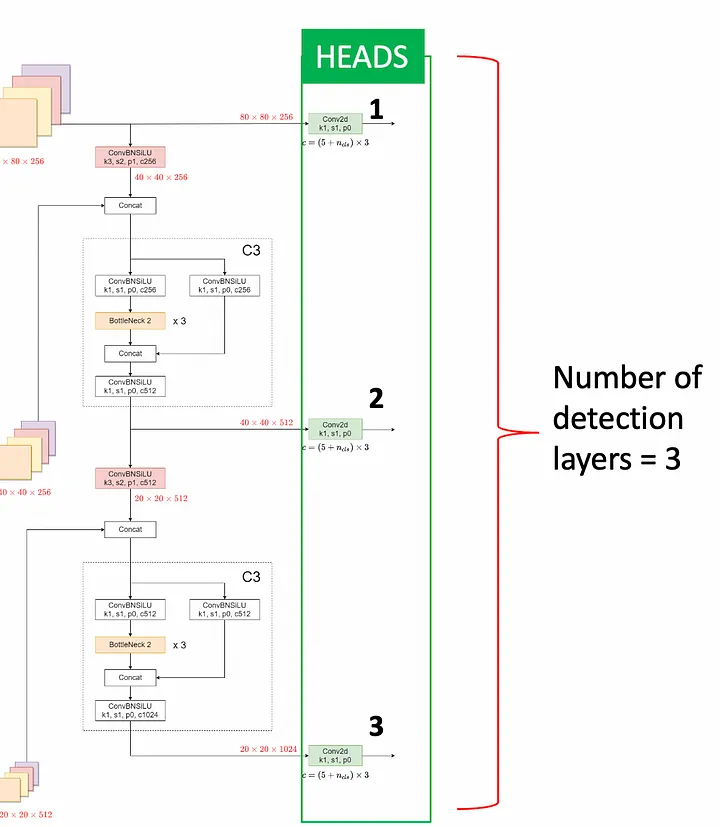

In [ ]:
# Each grid-cell is a vector of 5 + num_classes values which contains the following information:

# Objectness_score which represents the likelihood of the presence of (the centre of) an object within the grid-cell.
# Xc that represents the horizontal distance between the origin of the grid-cell (top-left) and the center of the object.
# Yc represents the vertical distance between the origin of the grid-cell (top-left) and the center of the object.
# Width is measured w.r.t the width of the grid-cell: considering the panther above, width is ~6.5 (details later in 2)Detection layers ) .
# Height is measured w.r.t the height of the grid-cell: considering the panther above, height is ~ 2.5 (details later in 2)Detection layers ) .
# Classes are a vector of len = len(n_classes) where the values represent the likelihood of an object belonging to each class.

In [ ]:
# Detection layers
# len(yolo_output) == num_detection_layers

In [ ]:
# In YOLO algorithms, a detection layer is a synonym for the head. 
# YOLOv5 default architecture uses 3 detection layers (first image of this chapter) and each one specializes in detecting objects of a given size. Precisely:

# the head 1 (80 x 80 grid cells) is suitable for detecting small objects
# the head 2 (40 x 40 grid cells) is suitable for detecting medium-sized objects
# the head 3 (20 x 20 grid cells) is suitable for detecting large objects

In [ ]:
# The first detection layer outputs a grid where each grid cell represents a width and a height of 8 pixels
# of the original input image (80x8 = 640).
# The second detection layer outputs a grid where each grid_cell represents a width and a height of 16 pixels 
# of the original input image (40x16 = 640).
# The third detection layer outputs a grid where each grid_cell represents a width and a height of 32 pixels 
# of the original input image (20x32 = 640).

In [ ]:
# In YOLOv5, [8, 16, 32] are referred as the “strides” of the model.

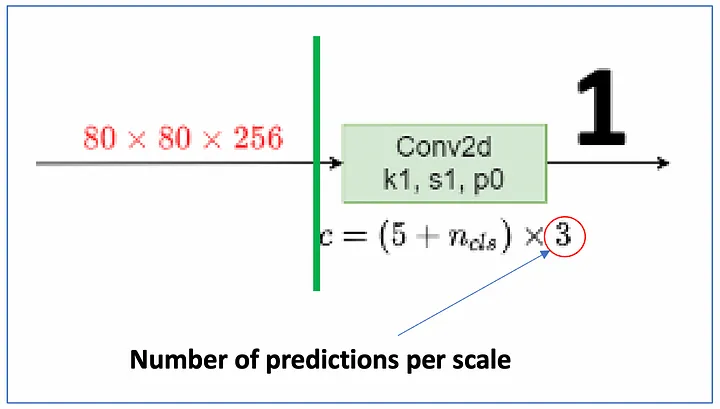

In [ ]:
# For example, the first detection-layer shown here will specialize at detecting 3 different sub-scales of small objects, such as

# small rectangular-horizontal objects
# small squared objects
# small rectangular-vertical objects

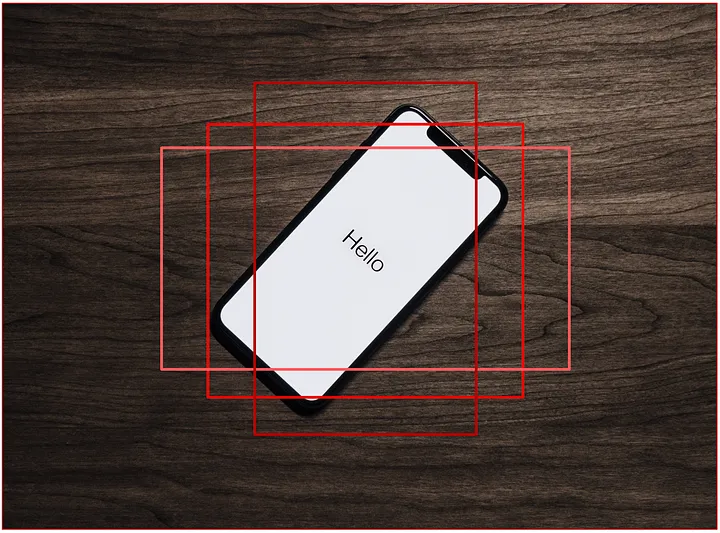

In [ ]:
"""Anchor Boxes
An anchor-box is a couple of 2 integers that indicate width and height expressed in pixels. In some cases, 
you can find it expressed with floats [0, 1] and represent W_box/default_image_size and H_box/default_image_size

(10, 13) means 10 pixels of width and 13 pixels of height

Anchor boxes (also referred to as anchors) are obtained by running K-Means clustering across the object labels, 
and the resulting K-centroids represent the main aspect-ratios (W, H) of the objects of the target datasets. 
Since a default YOLOv5 architecture has 3 detection layers and 3 predictions per scale, the standard number of anchors is 9.

Practical example. Consider:

- a dataset composed by 1000 images and 1 object per image.

-1000 object labels in YOLO format (class_idx, Xc, Yc, W, H)

- a default YOLOv5 model (3 heads and 3 scale-predictions per head) → 9 anchors

We subset all the object labels and we consider only [W, H] because we are interested only on the aspect-ratios 
of the objects and not on their location within images. On our [1000, 2] dataset, 
we run K-Means with n_centroids=9. The resulting 9 centroids are 9 couples of (W, H)
 that represent the average width and height of each scale.

Besides K-Means, Ultralytics adopts further techniques to compute anchors through the autoanchor algorithm. 
Glen Josher, YOLOv5 creator, explains that autoanchor “uses kmeans centroids as initial conditions for a Genetic Evolution (GE) algorithm. 
The GE algorithm will evolve all anchors for 1000 generations under default settings, 
using CIoU loss (same regression loss used during training) combined with Best Possible Recall (BPR) as its fitness function.”"""

In [ ]:
# Using Anchor boxes is way to encode previous knowledge into the model before starting the training process
# In other words, before the training process, we are already telling the model which is the (average) aspect-ratios 
# of the objects that it has to detect. The great advantage of using anchor-boxes is that they tremendously reduce the amount 
# of training data necessary to obtain good detections.

In [ ]:
# ----------From grid cells to bounding boxes--------------------
# To complete our YOLOv5, we need to solve these last two problems:
# Integrate the output of the model with anchors
# Transform the output coordinates from being w.r.t. grid cells to being w.r.t. the image (bounding boxes).
# These two tasks, despite being related to different problems, are commonly grouped together and are solved through the formulas shown below:

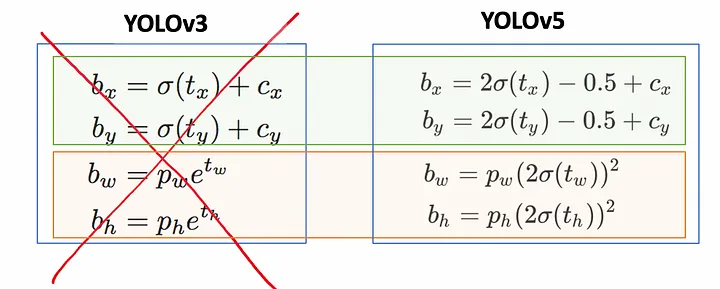

In [ ]:
"""Green rectangle: the transformation of the output coordinates from being w.r.t. grid cells to being w.r.t. the image.
Orange rectangle: integration of the output of the model with anchors by ensuring that f(0)=1"""

In [ ]:
"""
Example: after feeding a (3, 640, 640) input-image to a YOLOv5 model created to detect 80 classes, 
the final output is a list output whose lenght is equals to len(n_detection layers). Each element of output is going to be:

output[0].shape = (batch_size, 3, 80, 80, 85)

output[1].shape = (batch_size, 3, 40, 40, 85)

output[2].shape = (batch_size, 3, 20, 20, 85)

Where 3 is n_predictions_per_scale. [80, 80], [40, 40], [20, 20] are the dimensions of the “grids of grid_cells”. 
85, result of 5 + n_classes, are the values present in each grid_cell.
"""

In [6]:
class HEADS(nn.Module):
    def __init__(self, nc=80, anchors=(), ch=()):
      super(HEADS,self).__init__()
      self.nc = nc 
      self.nl = len(anchors)
      self.naxs = len(anchors[0])
      self.stride = [8,16,32] 
      anchors_ = torch.tensor(anchors).float().view(self.nl,-1,2) / torch.tensor(self.stride).repeat(6,1).T.reshape(3,3,2)
      self.register_buffer("anchors",anchors_)
      self.out_convs = nn.ModuleList()
      for in_channels in ch:
        self.out_convs += [nn.Conv2d(in_channels=in_channels,out_channels= (5 + self.nc) * self.naxs,kernel_size=1)]
                                     
      def forward(self,x):
        for i in range(self.nl):
          x[i] = self.out_convs[i](x[i])
          bs,_,grid_y,grid_x = x[i].shape 
          x[i] = x[i].view(bs,self.naxs,(5+self.nc),grid_y,grid_x).permute(0,1,3,4,2)
        return x 

In [ ]:
# register_buffer() is used to store the parameters of the model “which should be saved and restored in the state_dict,
# but are not trained by the optimizer”. 
# Anchors are strided. In other words, for each detection layer, 
# anchors are divided by the corresponding stride: (10, 13) is stored as (10/8, 13/8) →(1.25, 1.625)

In [ ]:
"""To select the bounding box coordinates from a tensor of shape (batch_size, num_anchors_per_scale, grid_size, grid_size, 5+n_classes) 
using ..., we can use the following indexing:

bounding_box = tensor[..., :4]
Here, the :4 selects all elements up to the fourth index, which correspond to the bounding box coordinates (x, y, w, h). 
The resulting tensor bounding_box will have shape (batch_size, num_anchors_per_scale, grid_size, grid_size, 4).

Note that the last dimension of the tensor, which contains the objectness score and class probabilities, is not selected here. 
If we want to select the objectness score, we can use the following indexing:
objectness = tensor[..., 4:5]
Here, the 4:5 selects only the fifth element, which corresponds to the objectness score. 
The resulting tensor objectness will have shape (batch_size, num_anchors_per_scale, grid_size, grid_size, 1).

If we want to select the class probabilities, we can use the following indexing:
class_probs = tensor[..., 5:]
Here, the 5: selects all elements starting from the sixth index, which correspond to the class probabilities. 
The resulting tensor class_probs will have shape (batch_size, num_anchors_per_scale, grid_size, grid_size, num_classes), 
where num_classes is the number of object classes being detected by the model.


the shape (batch_size, -1, 6) indicates that the tensor has 3 dimensions with sizes batch_size,
 an unknown number of boxes (which will be inferred based on the input size), and 6 elements per box.

By using -1 in the second dimension, we allow the tensor to have a variable number of boxes for each batch, 
since this dimension is being inferred automatically based on the other dimensions and the total number of elements."""

In [ ]:
def make_grids(anchors,naxs,stride,nx=20,ny=20,i=0):
  x_grid = torch.arange(nx)
  x_grid = x_grid.repeat(ny).reshape(nx,ny)
  y_grid = torch.arange(ny).unsqueeze(0)
  y_grid = y_grid.T.repeat(1,nx).reshape(nx,ny)
  xy_grid = torch.stack([x_gird,y_grid],dim=-1)
  xy_grid = xy_grid.expand(1,naxs,ny,nx,2)
  anchor_grid = (anchors[i]*stride).reshape((1,naxs,1,1,2)).expand(1,naxs,ny,nx,2)
  
  return xy_grid,anchor_grid 

def cells_to_bboxes(predictions, anchors, strides):
  num_out_layers = len(predictions)
  grid = [torch.empty(0) for _ in num_out_layers]
  anchor_grid = [torch.empty(0) for _ in num_out_layers]
  all_bboxes = []

  for i in range(num_out_layers):
    bs,naxs,ny,nx,_ = predictions[i].shape 
    stride = stride[i]
    grid[i],anchor_grid[i] = make_grids(anchors,naxs,stride,ny=ny,nx=nx,i=i)
    layer_predictions = predictions[i].sigmoid()
    obj = layer_predictions[...,4:5]

    xy = (2 * (layer_prediction[...,0:2]) + grid[i] - 0.5) * stride 
    wh = ((2 *layer_prediction[...,2:4]) ** 2) * anchor_grid[i]

    best_class = torch.argmax(layer_predictions[...,5:],dim=-1).unsqueeze(-1)
    scale_boxes = torch.cat((best_class,obj,xy,wh),dim=-1).reshape(bs,-1,6)
    all_boxes.append(scale_boxes)

  return torch.cat(all_boxes,dim=1)

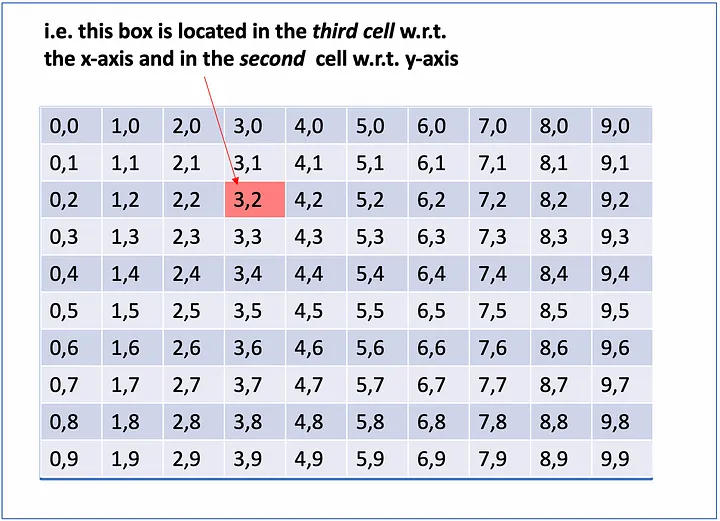

In [ ]:
"""model strides of [8, 16, 32]
a YOLOv5 output that is a list of len(n_detection_layer)
output[0] of shape (bs, predictions_x_scale, 10, 10, 85) where 10 and 10 are the dimensions of the grid of grid cells
1 object is detected in (3, 2), as in the image above and its values are [obj_score=0.55, xc=0,2, yc=0.1, w=1.22, h=1.36, …n_class_prob]
By summing 3 + 0.2 (grid x coord and xc) and 2 + 0.1 (grid y coord and yc) we get (3.2, 2.1) 
and by multiplying it by the width of the grid cells (same as strides[0]) we get (3.2, 2.1)*8=(25.6, 16.8) which is the final center of our bounding box!

In reality, we have to compute the coordinates with YOLOv5 above formulas."""

anchor grid 

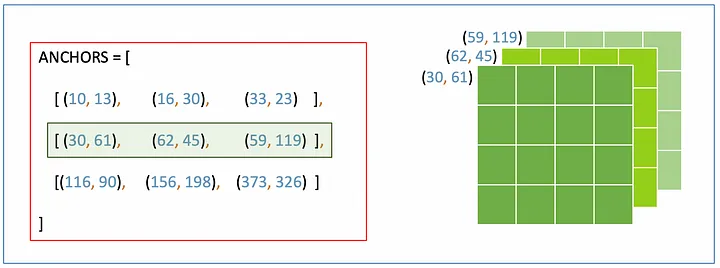

In [ ]:
# The Anchor grid makes sure that for each detection layer, 
# the W and H of the grid_cells ( [obj_score=0.55, xc=0,2, yc=0.1, w=1.22, h=1.36, …n_class_prob])
#  are multiplied for their respective anchor boxes. For example, as shown in the image, 
#  all the w and h of the grid cells in the first grid (darker one) are multiplied by 30 and 61.